<a href="https://www.kaggle.com/code/dascient/yahoo-s-top-gainers-kalman-forecasting-model?scriptVersionId=187627869" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Information and market data collected from Yahoo - https://finance.yahoo.com/gainers/
## Please do not consider the recommendations below as valid. Trade at your own discretion. 

In [21]:
# source
# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install yfinance --upgrade --no-cache-dir
!pip install plotly
!pip install pykalman
!pip install pandas_ta

from IPython.display import clear_output
import plotly.graph_objects as go
import warnings,time,ast
from pykalman import KalmanFilter
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil.tz import tzlocal
from rich import print, pretty
from datetime import datetime
from random import randint
from random import seed
import pandas_ta as ta
import yfinance as yf
import pandas as pd
import numpy as np
import lxml.html
import requests
import os

clear_output()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
def calculate_symbol(df):
    
    df['close'] = df['Close']
    df['low'] = df['Low']
    df['high'] = df['High']
    df['open'] = df['Open']
    
    close = df['close'][len(df)-1]
    low = df['low'][len(df)-1]

    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                      observation_matrices = [1],   # The value for Ht.
                      initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                      initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                      observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                      transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
    # Get the Kalman smoothing
    state_means, _ = kf.filter(df['close'].values)
    # Call it kf_mean
    df['kf_mean'] = np.array(state_means)
    kalman = df.kf_mean[len(df)-1]
    aboveKalman = low > kalman


    # exponential moving averages 
    ema_13 = df.ta.ema(13, append=True)[-1:].reset_index(drop=True)[0]
    ema_31 = df.ta.ema(31, append=True)[-1:].reset_index(drop=True)[0]
    ema_crossover = ema_13 > kalman


    # lower/upper 14-day bollinger bands for mean reversion
    bbl_14 = df.ta.bbands(length=14, append=True)[['BBL_14_2.0']].tail(1).values[0][0]
    bbu_14 = df.ta.bbands(length=14, append=True)[['BBU_14_2.0']].tail(1).values[0][0]
    bband_buy = close < bbl_14
    bband_sell = close > bbu_14


    # ichimoku 9 & 26-day forecasts 
    # https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.IchimokuIndicator
    isa_9 = df.ta.ichimoku()[1]['ISA_9'].tail(1).values[0] # help(ta.ichimoku)
    isb_26 = df.ta.ichimoku()[1]['ISB_26'].tail(1).values[0]


    # archer ma 
    # https://github.com/twopirllc/pandas-ta#general
    amat = (df.ta.amat()['AMATe_LR_8_21_2'].tail(1).values[0] == 1)


    # rsi
    rsi = df.ta.rsi()[len(df)-1]
    rsi_buy = rsi < 30
    rsi_sell = rsi > 70


    # choppy
    # https://github.com/twopirllc/pandas-ta#trend-18
    try: 
        chop = "{:.2f}".format(df.ta.chop()[len(df.ta.chop())-1]) 
    except RunTimeWarning:
        chop = 0


    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    # signal
    #buy = (close < isa_9) & (close < isb_26) & amat & rsi_buy & bband_buy & aboveKalman
    
    # kalman is accounted for in the ema_crossover
    buy = amat & ema_crossover# & aboveKalman

    #sell = (close > isa_9) & (close > isb_26) & ~amat & rsi_sell & bband_sell & ~aboveKalman
    
    # kalman is accounted for in the ema_crossover
    sell = ~amat & ~ema_crossover# & ~aboveKalman
    
    return df, close, isa_9, isb_26, chop, rsi, amat, ema_crossover, buy, sell, aboveKalman

# plotter
def plot(df,symbol):
    fig = go.Figure(go.Candlestick(x=df.index,
                                   open=df['open'],
                                   high=df['high'],
                                   low=df['low'],
                                   close=df['close'],
                                   name=symbol,
                                  ))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['kf_mean'], 
                             opacity=0.7, 
                             line=dict(color='purple', width=2), 
                             name='Kalman Filter'))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_13'], 
                             opacity=0.7, 
                             line=dict(color='orange', width=2), 
                             name='EMA_13'))
    
    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_31'], 
                             opacity=0.7, 
                             line=dict(color='lightblue', width=2), 
                             name='EMA_31 '))
    
    fig.update_layout(title=f'Ticker: {symbol}')
    fig.update_layout(xaxis_rangeslider_visible=False)
    return fig.show()

# [Fear & Greed Index](https://www.cnn.com/markets/fear-and-greed)

In [23]:
!pip install fear-and-greed
clear_output()

import fear_and_greed
#type(fear_and_greed.get())

print('\nIndex: ',fear_and_greed.get()[0])
print('Range: ',fear_and_greed.get()[1])
print('Datetime: ',fear_and_greed.get()[2])

Index:  52.2571428571429

Range:  neutral

Datetime:  2024-07-10 00:59:37+00:00

# Today's Yahoo Gainers 
## Including Recommendations, Candlesticks, Closing Price, Ichimoku 9 & 26 Day Spans, Choppiness, RSI, Exponential Moving Averages (EMA) & Kalman Forecast Predictors. 
### This notebook only plots entry & exit stocks out of the 100 from Yahoo's Gainers webpage.

In [24]:
from datetime import datetime
today = pd.Timestamp(datetime.now(), tz='EST').strftime("%Y-%m-%d")
print(f"Calculating indicators for today's date: {today}.")

Calculating indicators for today's date: 2024-07-10.

# Entry Points

Entry Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: RVMD

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 43.91999816894531

Ichimoku 9-Day Forecast: 40.644999504089355

Ichimoku 26-Day Forecast: 39.72500038146973

Choppiness (%): 35.71

RSI: 71.05016201027702

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

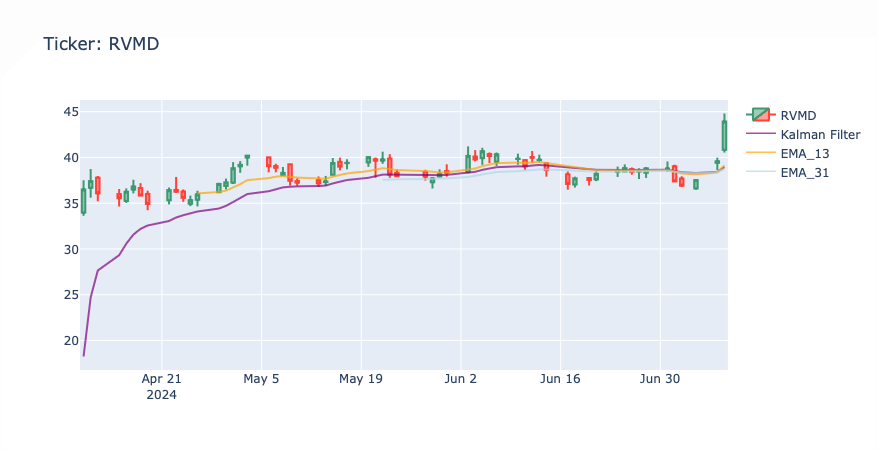

Ticker: EWTX

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 22.850000381469727

Ichimoku 9-Day Forecast: 19.730000257492065

Ichimoku 26-Day Forecast: 19.09000015258789

Choppiness (%): 35.19

RSI: 75.35826449951358

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

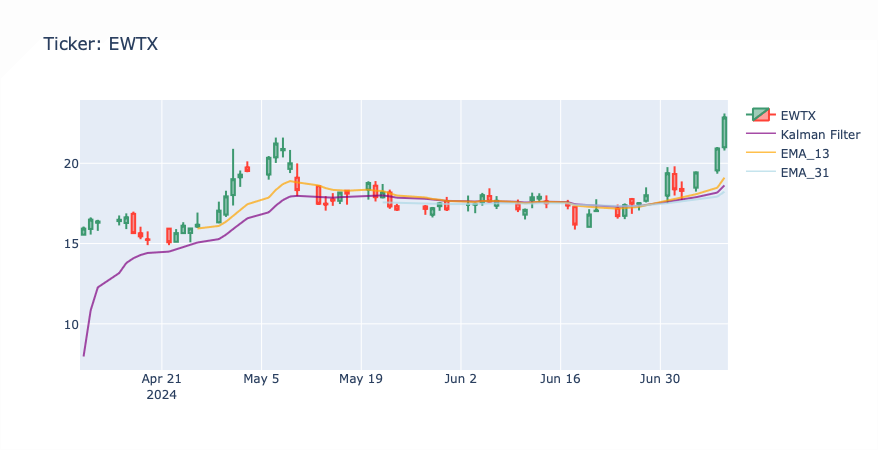

Ticker: YY

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 34.93000030517578

Ichimoku 9-Day Forecast: 31.897500038146973

Ichimoku 26-Day Forecast: 31.619999885559082

Choppiness (%): 22.15

RSI: 78.19891221375738

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

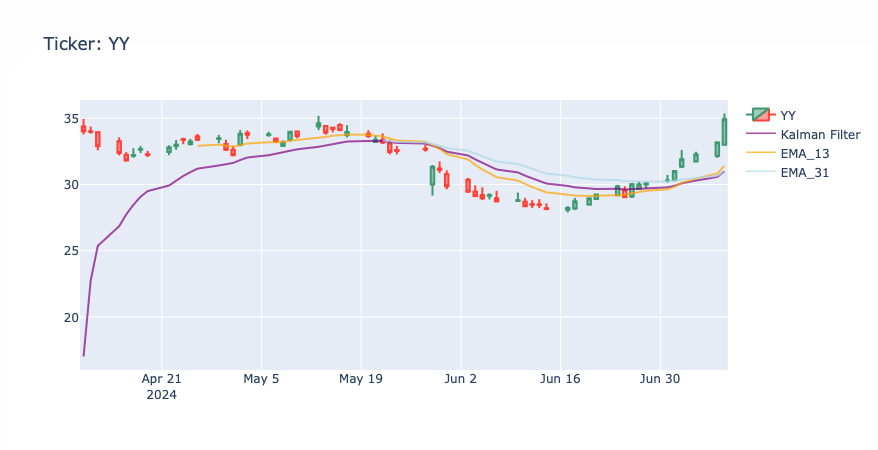

Ticker: TLNE

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 125.01000213623047

Ichimoku 9-Day Forecast: 117.50750350952148

Ichimoku 26-Day Forecast: 111.80000305175781

Choppiness (%): 34.88

RSI: 69.59248672382368

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

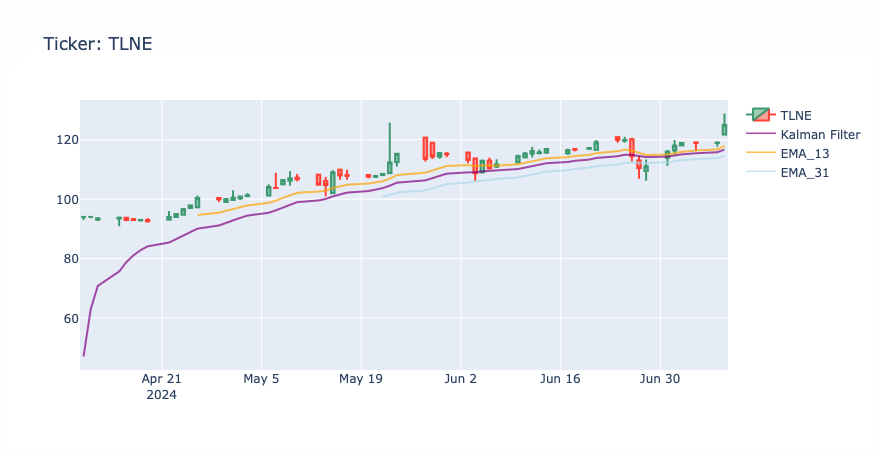

Ticker: ARGX

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 457.67999267578125

Ichimoku 9-Day Forecast: 427.3550109863281

Ichimoku 26-Day Forecast: 406.23500061035156

Choppiness (%): 32.99

RSI: 73.11462033342622

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

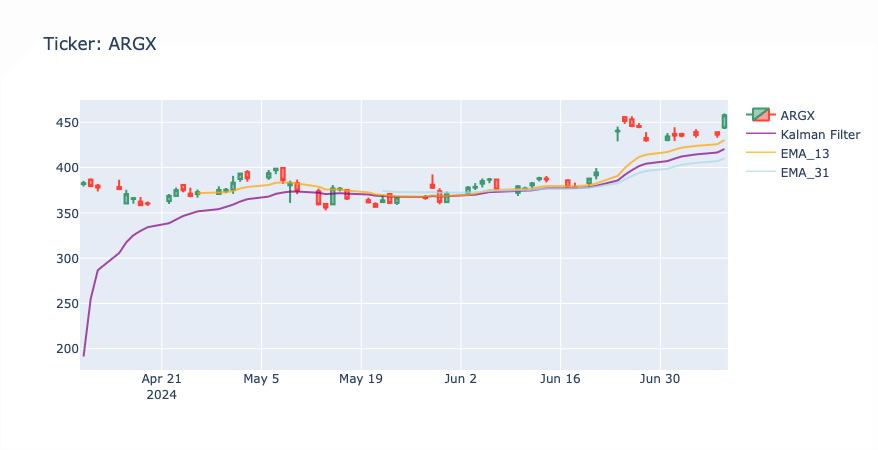

Ticker: SONY

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 90.44000244140625

Ichimoku 9-Day Forecast: 85.6500015258789

Ichimoku 26-Day Forecast: 82.82500076293945

Choppiness (%): 20.74

RSI: 70.5903839598402

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

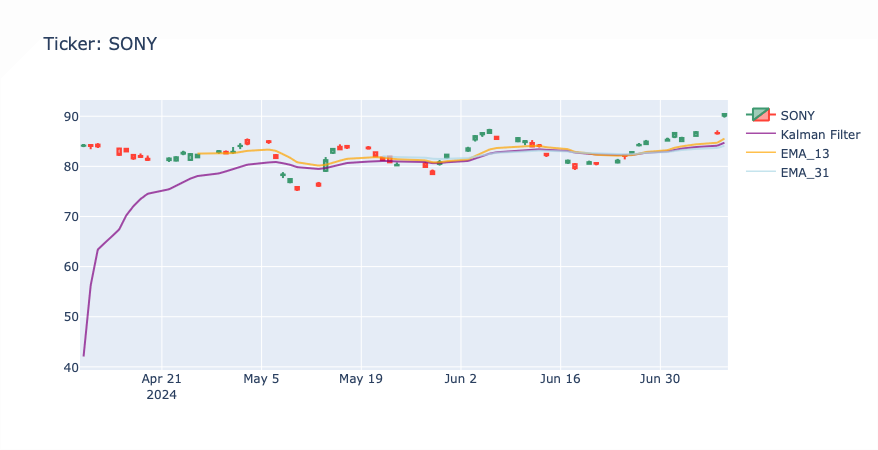

Ticker: GLW

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 44.66999816894531

Ichimoku 9-Day Forecast: 41.13749980926514

Ichimoku 26-Day Forecast: 38.125

Choppiness (%): 32.12

RSI: 80.18089426728557

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

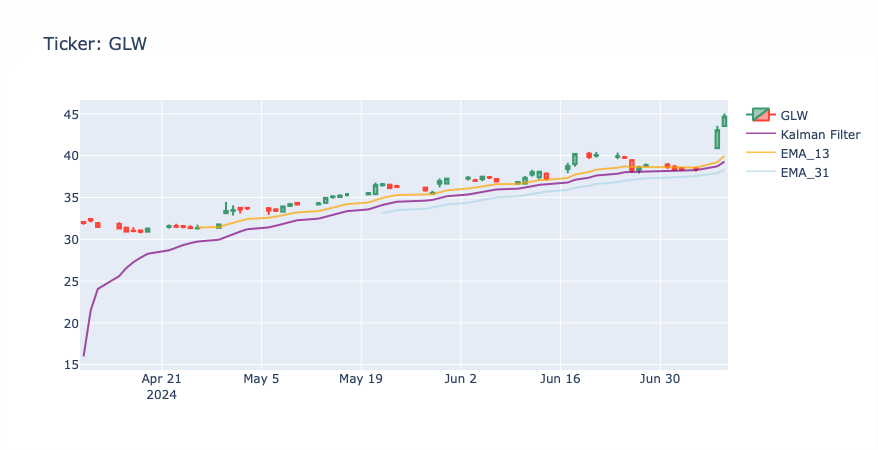

Ticker: GDS

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 12.260000228881836

Ichimoku 9-Day Forecast: 10.437499761581421

Ichimoku 26-Day Forecast: 9.68999981880188

Choppiness (%): 26.94

RSI: 82.98376176205657

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

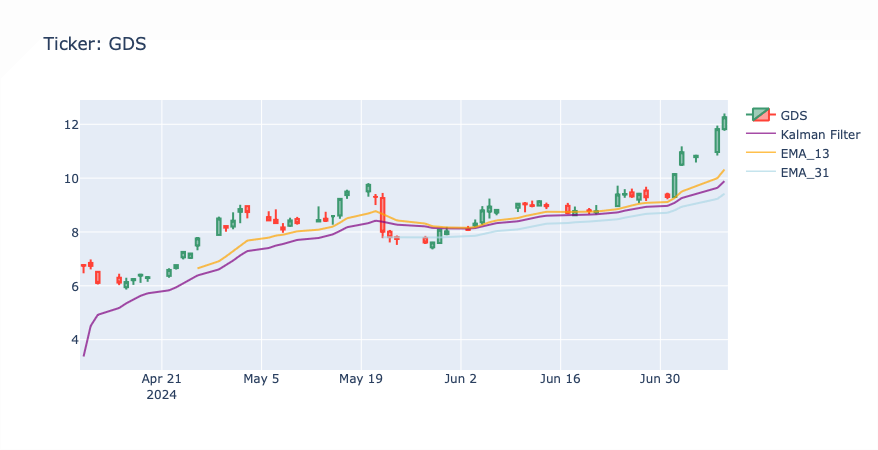

Ticker: SITM

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 147.60000610351562

Ichimoku 9-Day Forecast: 132.17499923706055

Ichimoku 26-Day Forecast: 111.21999740600586

Choppiness (%): 34.72

RSI: 74.69493920161617

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

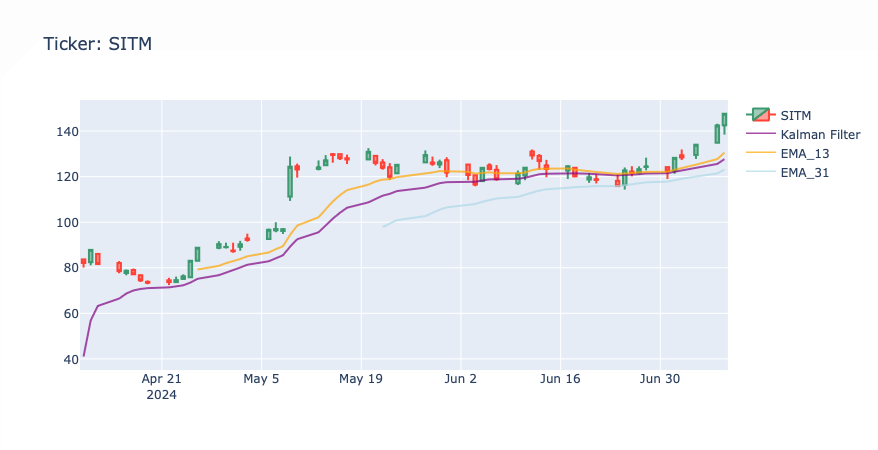

Ticker: TSLA

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 262.3299865722656

Ichimoku 9-Day Forecast: 221.24749374389648

Ichimoku 26-Day Forecast: 211.55998992919922

Choppiness (%): 19.57

RSI: 87.3224555262755

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

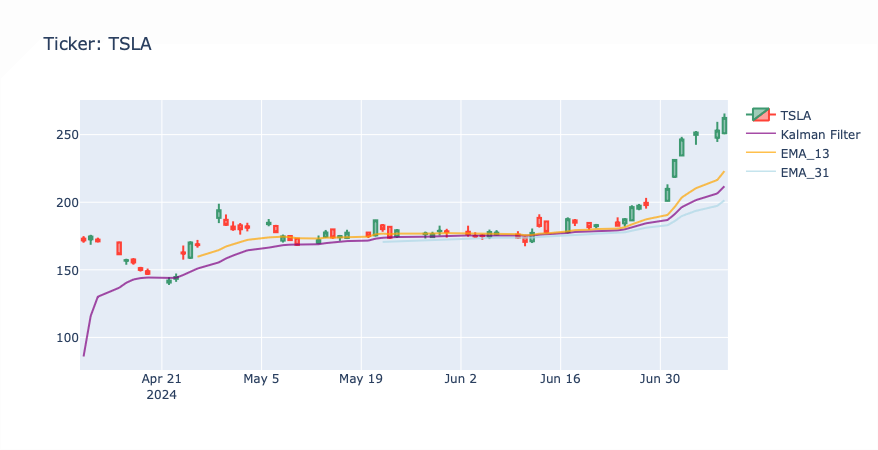

Ticker: ROKU

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 63.11000061035156

Ichimoku 9-Day Forecast: 58.309998512268066

Ichimoku 26-Day Forecast: 59.045000076293945

Choppiness (%): 34.46

RSI: 65.41187738200243

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

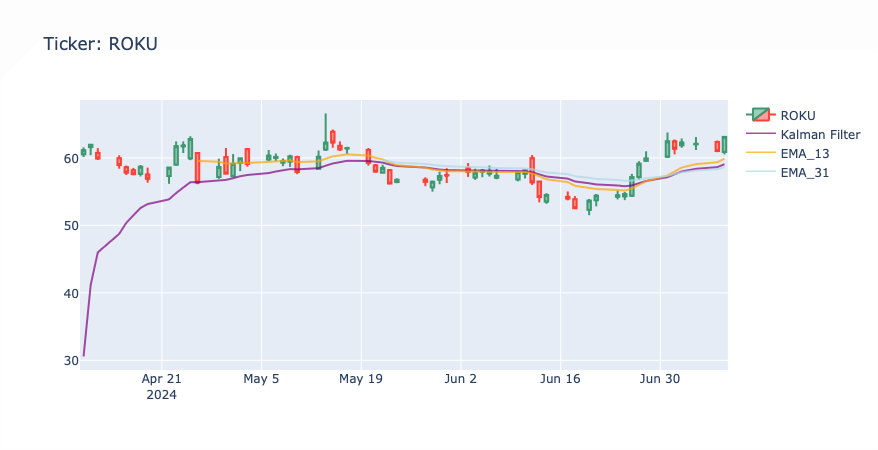

In [27]:
# Plotly within a double nested for-loop. 
# This pulls from Yahoo's Gainers first page, then implements technical indicators to output forecasts, 
# RSI, choppiness, trend archers, & other conditionals to aid in decision making.

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Pull Yahoo's Top Gainers of Today - first page.

url = 'https://finance.yahoo.com/gainers?count=100&offset=0'
headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
}

ytext = requests.get(url,headers=headers).text
yroot = lxml.html.fromstring(ytext)
List = []
for x in yroot.xpath('//*[@id="fin-scr-res-table"]//a'):
    List.append({"top_movers":x.attrib['href'].split("/")[-2].split("?")[0]})
List = pd.DataFrame(List)

# calculating plotter
print('\n Entry Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if (calculate_symbol(v)[8] == True) & (calculate_symbol(v)[4]<="40"):
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

# Exit Points

Exit Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: ZI

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 12.470000267028809

Ichimoku 9-Day Forecast: 12.282999992370605

Ichimoku 26-Day Forecast: 14.250499725341797

Choppiness (%): 60.30

RSI: 49.21533468820559

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

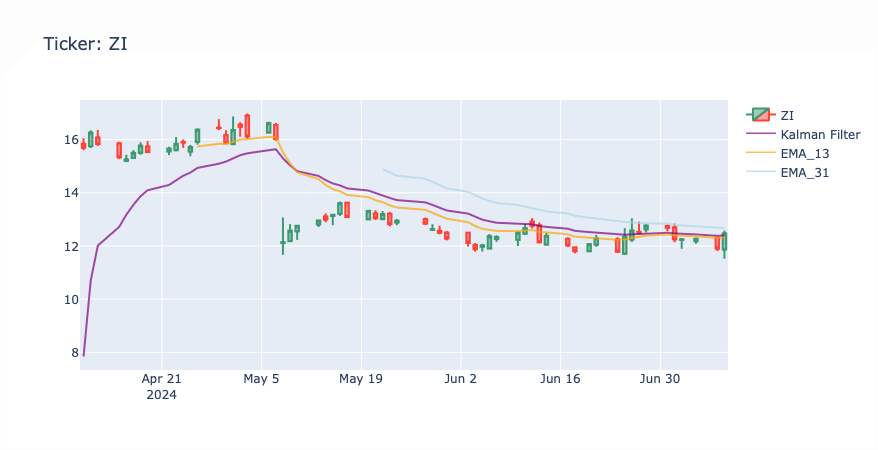

Ticker: SGRY

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 24.059999465942383

Ichimoku 9-Day Forecast: 24.34500026702881

Ichimoku 26-Day Forecast: 25.399999618530273

Choppiness (%): 57.43

RSI: 47.3323670165413

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

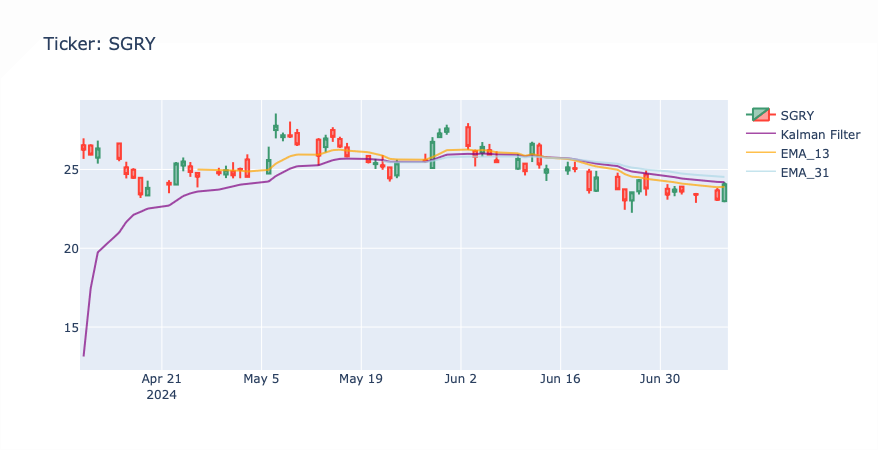

Ticker: IOVA

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 7.539999961853027

Ichimoku 9-Day Forecast: 8.055000066757202

Ichimoku 26-Day Forecast: 10.699999809265137

Choppiness (%): 53.36

RSI: 33.91697900235819

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

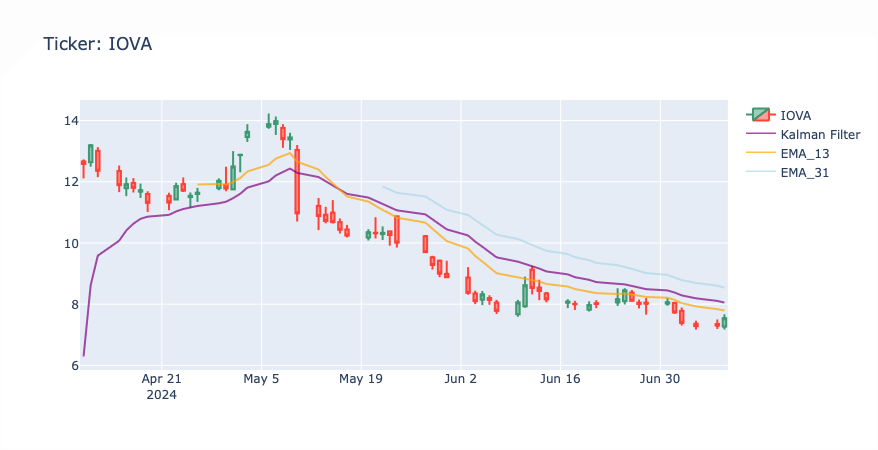

Ticker: WBD

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 7.340000152587891

Ichimoku 9-Day Forecast: 7.5

Ichimoku 26-Day Forecast: 7.819999933242798

Choppiness (%): 66.98

RSI: 46.12570860808184

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

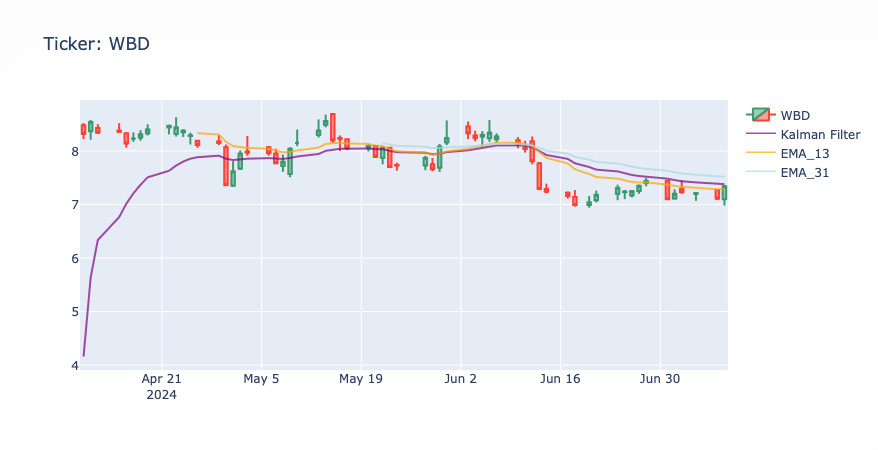

In [28]:
print('\n Exit Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if (calculate_symbol(v)[9] == True) & (calculate_symbol(v)[4] >= "50"):
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

# Portfolio

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Ticker: AAPL

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 228.67999267578125

Ichimoku 9-Day Forecast: 214.75249862670898

Ichimoku 26-Day Forecast: 197.80500030517578

Choppiness (%): 41.04

RSI: 76.38070015861805

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

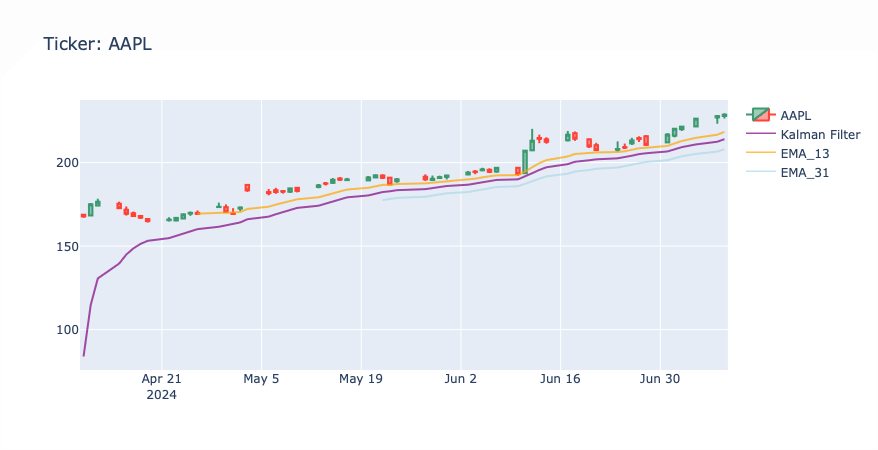

Ticker: AI

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 29.440000534057617

Ichimoku 9-Day Forecast: 29.393749713897705

Ichimoku 26-Day Forecast: 27.22000026702881

Choppiness (%): 47.52

RSI: 56.9286342660941

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: False

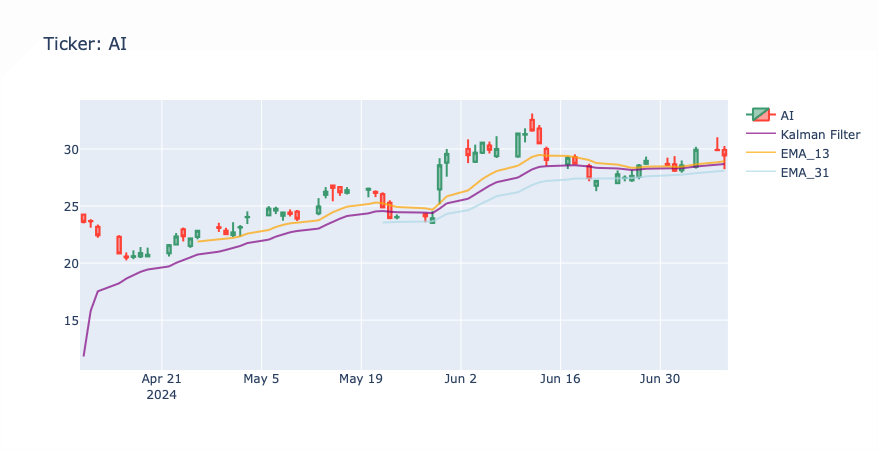

Ticker: FCEL

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 0.6299999952316284

Ichimoku 9-Day Forecast: 0.7275000065565109

Ichimoku 26-Day Forecast: 0.8149999976158142

Choppiness (%): 45.24

RSI: 37.46197888029139

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

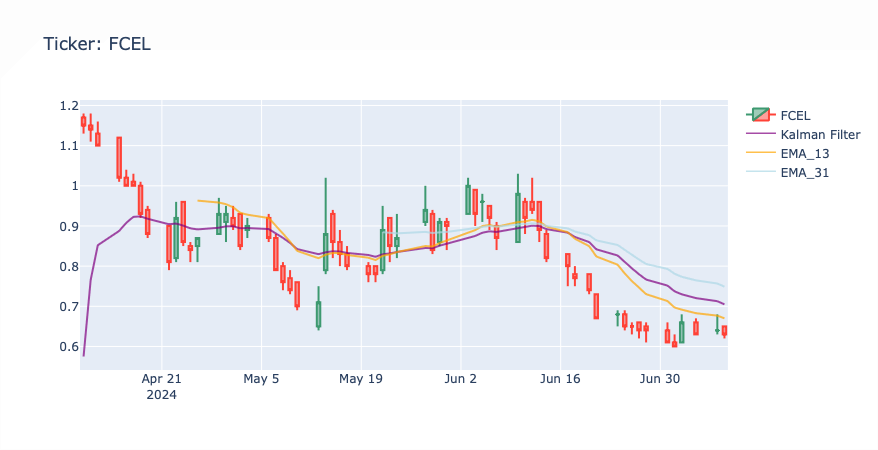

Ticker: NOC

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 423.7300109863281

Ichimoku 9-Day Forecast: 434.0449981689453

Ichimoku 26-Day Forecast: 454.6000061035156

Choppiness (%): 62.61

RSI: 33.43998930913495

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

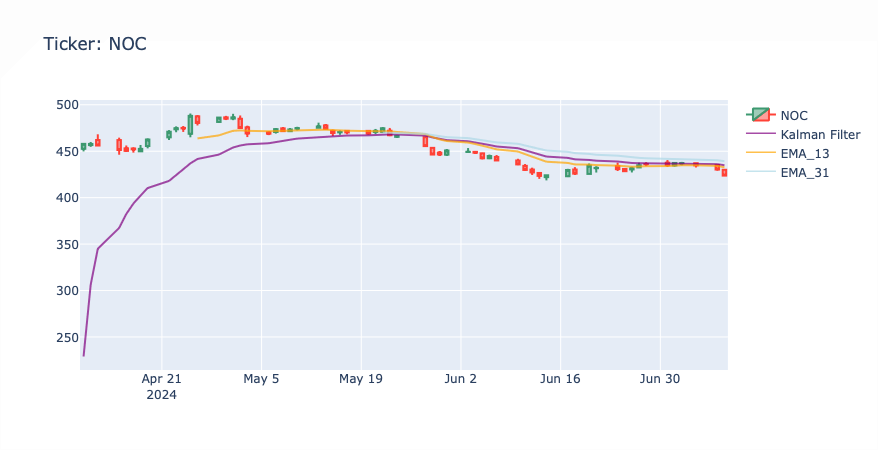

Ticker: PLTR

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 27.389999389648438

Ichimoku 9-Day Forecast: 25.44749927520752

Ichimoku 26-Day Forecast: 24.4399995803833

Choppiness (%): 41.67

RSI: 69.34130199719718

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

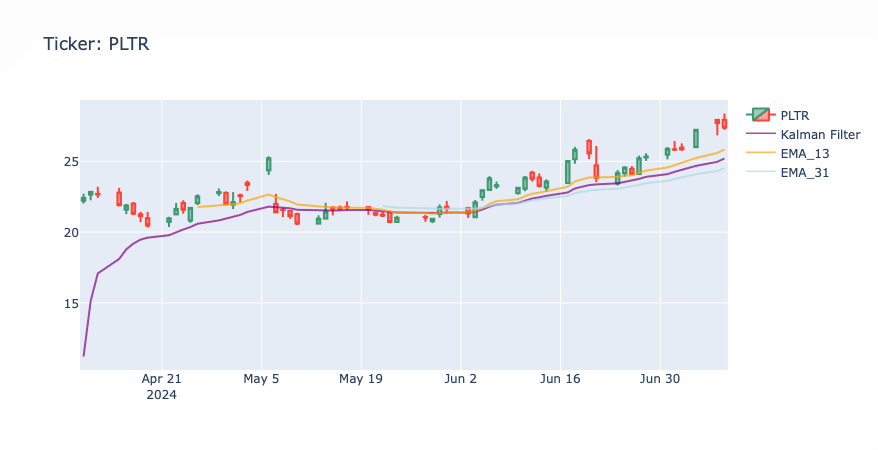

Ticker: SBUX

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 72.75

Ichimoku 9-Day Forecast: 77.0825023651123

Ichimoku 26-Day Forecast: 80.7650032043457

Choppiness (%): 27.33

RSI: 25.082447930036526

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

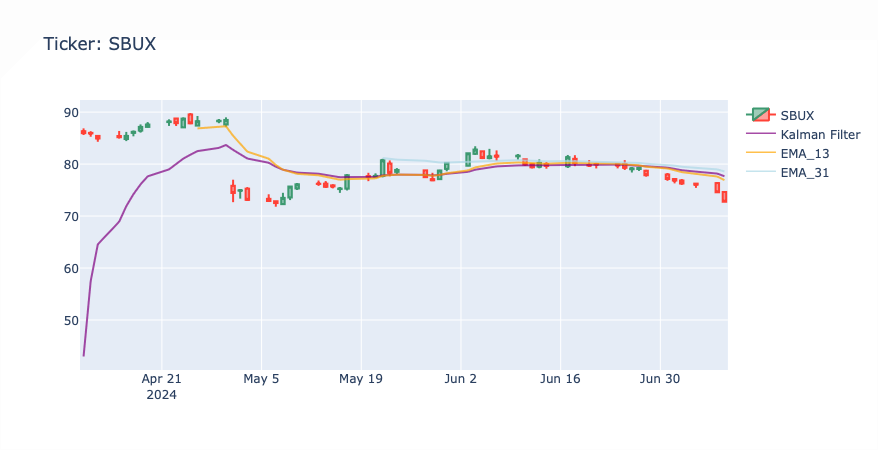

Ticker: TSLA

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 262.3299865722656

Ichimoku 9-Day Forecast: 221.24749374389648

Ichimoku 26-Day Forecast: 211.55998992919922

Choppiness (%): 19.57

RSI: 87.3224555262755

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

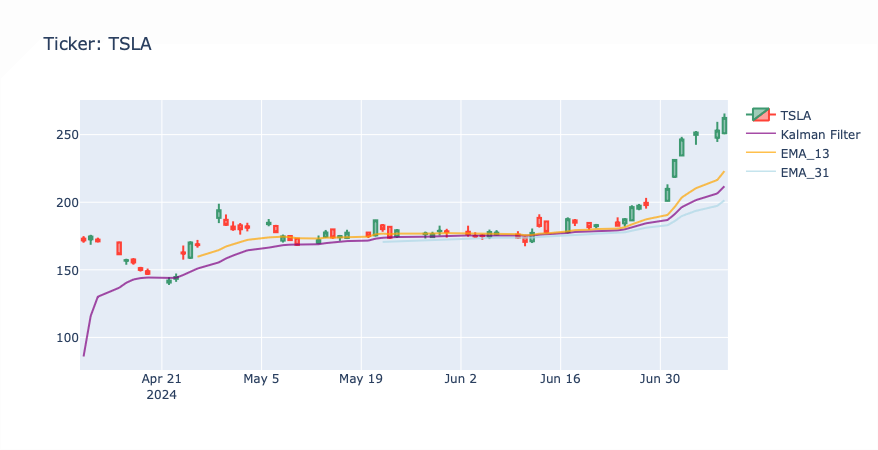

In [30]:
# calculating plotter
Portfolio = ['AAPL','AI','FCEL','NOC','PLTR','SBUX','TSLA']
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for v in Portfolio]: 
    print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40):',calculate_symbol(v)[8])
    print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
    print('\n\nClose:',calculate_symbol(v)[1])
    print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
    print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
    print('Choppiness (%):',calculate_symbol(v)[4])
    print('RSI:',calculate_symbol(v)[5])
    print('Archer MA Trending:',calculate_symbol(v)[6])
    print('EMA_13 > Kalman:',calculate_symbol(v)[7])
    print('Low > Kalman:',calculate_symbol(v)[10])
    plot(v.tail(90),i)
else:pass

In [31]:
# choppiness
print("Choppiness:")
help(ta.chop)

Choppiness:

Help on function chop in module pandas_ta.trend.chop:

chop(high, low, close, length=None, atr_length=None, ln=None, scalar=None, drift=None, offset=None, **kwargs)
    Choppiness Index (CHOP)
    
    The Choppiness Index was created by Australian commodity trader
    E.W. Dreiss and is designed to determine if the market is choppy
    (trading sideways) or not choppy (trading within a trend in either
    direction). Values closer to 100 implies the underlying is choppier
    whereas values closer to 0 implies the underlying is trending.
    
    Sources:
        https://www.tradingview.com/scripts/choppinessindex/
        https://www.motivewave.com/studies/choppiness_index.htm
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        HH = high.rolling(length).max()
        LL = low.rolling(length).min()
    
        ATR_SUM = SUM(ATR(drift), length)
        CHOP = scalar * (LOG10(ATR_SUM) - LOG10(HH - LL))
        CHOP /= LOG10(length)
    
    

In [32]:
# soon to incorporate this charting method: https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb

In [33]:
# en fin

# Disclaimer

All investments involve risk, and the past performance of a security, industry, sector, market, financial product, trading strategy, or individual’s trading does not guarantee future results or returns. Investors are fully responsible for any investment decisions they make. Such decisions should be based solely on an evaluation of their financial circumstances, investment objectives, risk tolerance, and liquidity needs.

Any opinions, news, research, analyses, prices, or other information offered is provided as general market commentary, and does not constitute investment advice. We will not accept liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.


# Supplementary

[*********************100%%**********************]  1 of 1 completed


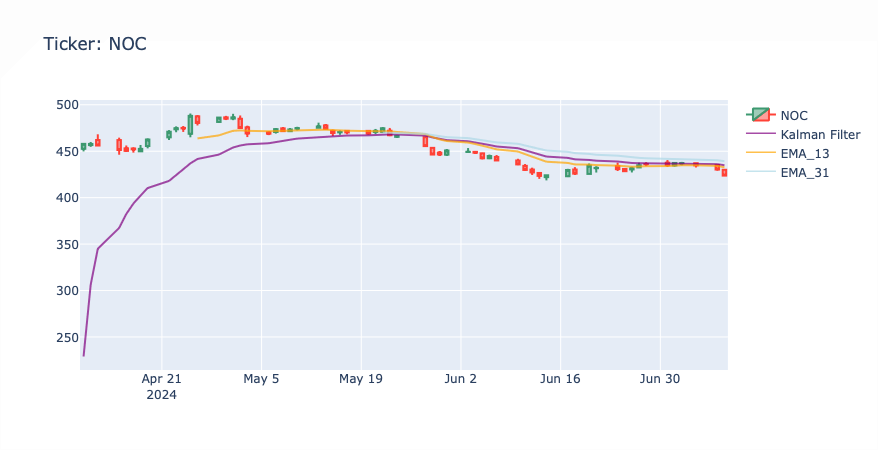

In [34]:
ticker = 'NOC'
df = yf.download(tickers=ticker, period='3mo', interval='1d')
calculate_symbol(df)
plot(df,ticker)


In [35]:
# Used for example Trend Return Long Trend Below
macd_ = ta.macd(df.Close)
macdh = macd_[macd_.columns[1]]
df.tail()

,Open,High,Low,Close,Adj Close,Volume,close,low,high,open,kf_mean,EMA_13,EMA_31,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0
Date,,,,,,,,,,,,,,,,,,
2024-07-02,434.720001,437.480011,433.660004,437.369995,437.369995,504000,437.369995,433.660004,437.480011,434.720001,436.839324,434.506048,441.637485,422.082726,430.765002,439.447277,4.031096,0.880372
2024-07-03,436.980011,438.510010,434.850006,437.089996,437.089996,304000,437.089996,434.850006,438.510010,436.980011,436.863169,434.875183,441.353267,422.471565,431.475002,440.478438,4.173329,0.811825
2024-07-05,437.089996,437.089996,432.489990,434.730011,434.730011,436700,434.730011,432.489990,437.089996,437.089996,436.660250,434.854445,440.939314,424.349350,432.282859,440.216367,3.670517,0.654229
2024-07-08,435.149994,436.130005,429.410004,430.250000,430.250000,727900,430.250000,429.410004,436.130005,435.149994,436.050471,434.196667,440.271232,426.076892,432.722859,439.368826,3.071697,0.313958
2024-07-09,430.000000,430.390015,423.679993,423.730011,423.730011,910300,423.730011,423.679993,430.390015,430.000000,434.878479,432.701430,439.237405,424.287370,432.290717,440.294064,3.702762,-0.034820


<Axes: title={'center': 'NOC'}, xlabel='Date'>

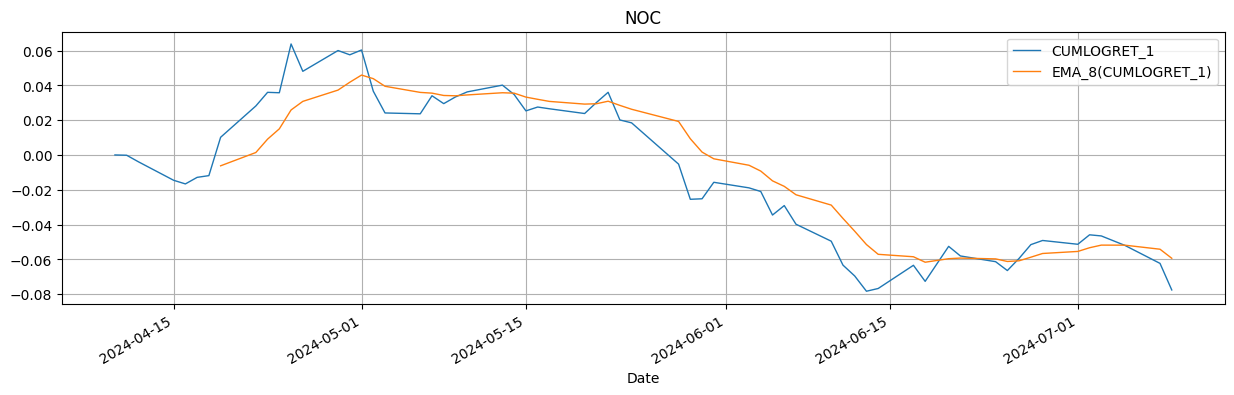

In [36]:
# cumulative log return
clr_ma_length = 8
clrdf = df.ta.log_return(cumulative=True, append=True)
clrmadf = ta.ema(clrdf, length=clr_ma_length)
clrxdf = pd.DataFrame({f"{clrdf.name}": clrdf, f"{clrmadf.name}({clrdf.name})": clrmadf})
clrxdf.plot(figsize=(15,4), linewidth=1, title=f"{ticker}", grid=True)

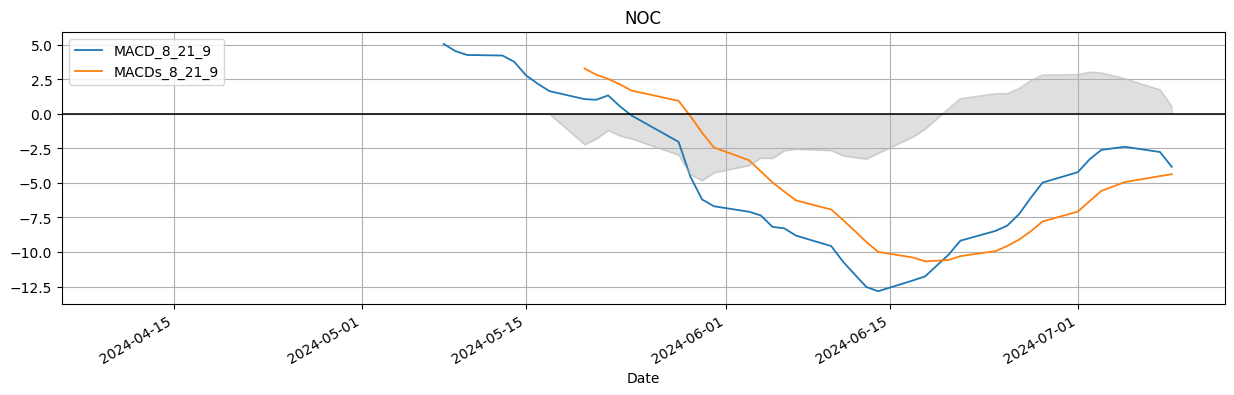

In [37]:
# macd
macddf = df.ta.macd(fast=8, slow=21, signal=9, min_periods=None, append=True)
macddf[[macddf.columns[0], macddf.columns[2]]].plot(figsize=(16, 2), linewidth=1.3)
macddf[macddf.columns[1]].plot.area(figsize=(15,4), stacked=False, color=["silver"], linewidth=1, title=f"{ticker}", grid=True).axhline(y=0, color="black", lw=1.1)